In [6]:
import os
from sklearn.model_selection import train_test_split
from PIL import Image
from skimage import morphology, filters
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm  # 导入tqdm库
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Softmax, Activation, BatchNormalization, \
    Flatten, Dropout, DepthwiseConv2D
from keras.utils import to_categorical
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import sys

In [7]:
NUM = 14

In [8]:
url = "https://file.liux.pro/d/public/ai-arithmetic/mnist14.tar.gz"
path_to_zip = tf.keras.utils.get_file(origin=url, cache_dir=".", cache_subdir="dataset", extract=True)
dataset_dir  = os.path.join(os.path.dirname(path_to_zip), 'mnist14')
print(dataset_dir)

38618744/38618744 [==============================] - 7s 0us/step
./dataset/mnist14


In [9]:
# 定义数据集路径
data_folder = dataset_dir

x_data = []
y_data = []
x_data_original = []  # 用于存储原始图像


# 定义细化处理函数
def thin_image(image):
    binary_image = image > filters.threshold_otsu(image)
    skeleton = morphology.skeletonize(binary_image)
    thin_image = (skeleton * 255).astype(np.uint8)
    return thin_image



# 加载图像和标签
for label in range(NUM):
    label_folder = os.path.join(data_folder, str(label))
    images = []
    original_images = []

    # 使用tqdm显示进度条
    for img_name in tqdm(os.listdir(label_folder), desc=f'Loading images for label {label}'):
        img_path = os.path.join(label_folder, img_name)

        # 加载并处理图像
        image = Image.open(img_path).convert('L')  # 转换为灰度图
        image = image.resize((28, 28))  # 调整大小

        image_array = np.array(image)

        # 存储原始图像
        original_images.append(image_array)

        # 细化处理
        image_array = thin_image(image_array)

        images.append(image_array)

    x_data.extend(images)
    y_data.extend([label] * len(images))
    x_data_original.extend(original_images)

# 转换为NumPy数组
x_data = np.array(x_data)
y_data = np.array(y_data)
x_data_original = np.array(x_data_original)

# 直接使用所有样本
x_balanced = x_data
y_balanced = y_data

# 按比例拆分数据集（例如，80% 训练集，20% 测试集）
x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.2, random_state=42)

# 确保数据集的形状符合TensorFlow的要求
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')

# 创建一个ImageDataGenerator实例并设置增强参数
datagen = ImageDataGenerator(
    rotation_range=1,
    zoom_range=(0.7, 1.0),
    # width_shift_range=0.1,
    height_shift_range=0.05
)
# 适配数据生成器
datagen.fit(x_train)

# 打印每种图片的数量
unique, counts = np.unique(y_balanced, return_counts=True)
print("每种图片数量:")
for label, count in zip(unique, counts):
    print(f'类别 {label}: {count} 张')


Loading images for label 13: 100%|██████████| 4234/4234 [00:01<00:00, 2501.79it/s]


每种图片数量:
类别 0: 11875 张
类别 1: 13533 张
类别 2: 11984 张
类别 3: 12215 张
类别 4: 11622 张
类别 5: 10875 张
类别 6: 11875 张
类别 7: 12496 张
类别 8: 11741 张
类别 9: 11784 张
类别 10: 5059 张
类别 11: 6500 张
类别 12: 5102 张
类别 13: 4234 张


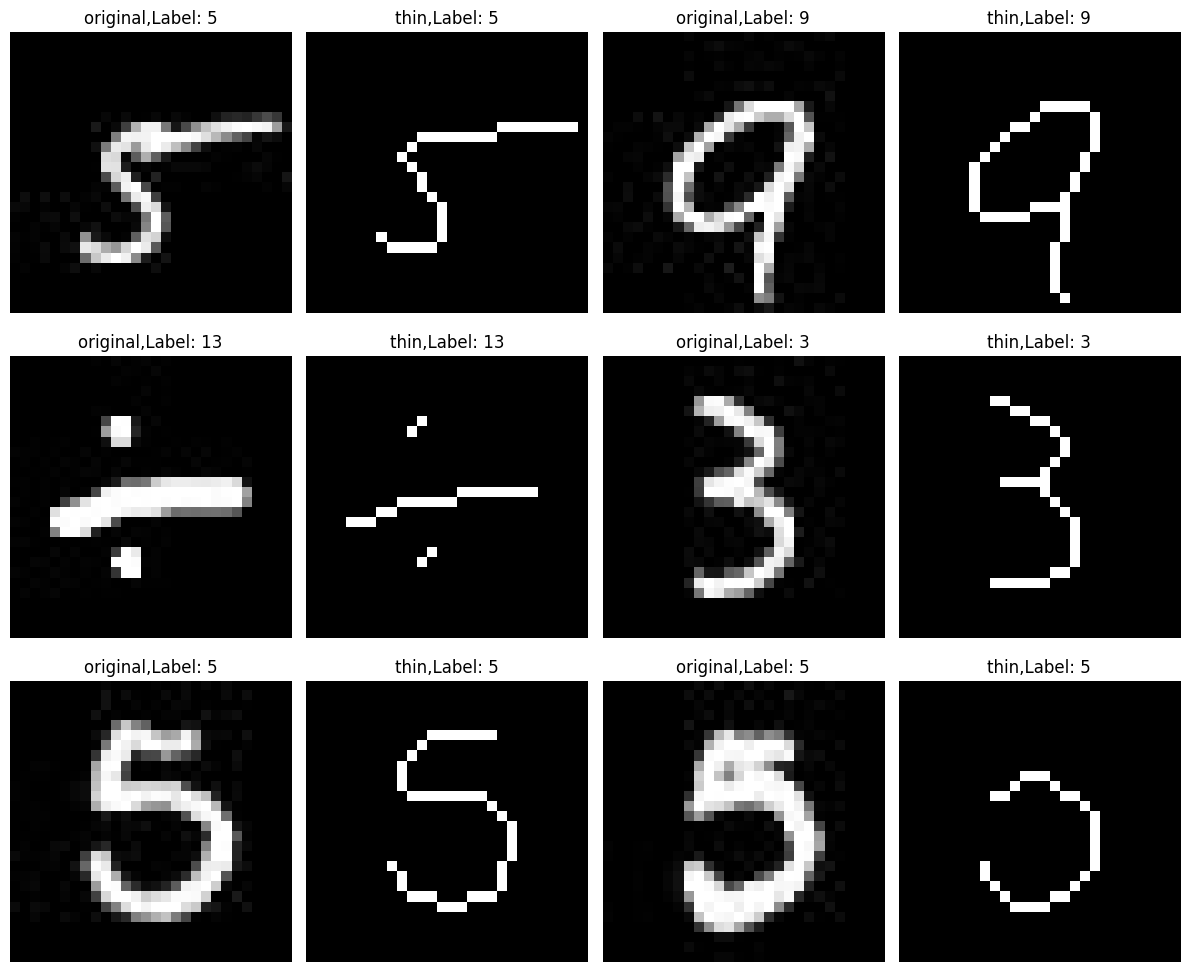

In [10]:
# 显示几个原始图像与细化后的对比图
fig, axes = plt.subplots(3, 4, figsize=(12, 10))

# 显示几个样本
for i in range(3):
    for j in range(2):
        idx = np.random.choice(len(x_data))  # 随机选择一个索引
        axes[i, j * 2].imshow(x_data_original[idx], cmap='gray')
        axes[i, j * 2].set_title(f"original,Label: {y_balanced[idx]}")
        axes[i, j * 2].axis('off')

        axes[i, j * 2 + 1].imshow(x_data[idx], cmap='gray')
        axes[i, j * 2 + 1].set_title(f"thin,Label: {y_balanced[idx]}")
        axes[i, j * 2 + 1].axis('off')

plt.tight_layout()
plt.show()

In [11]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1) / 255
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1) / 255

y_train = to_categorical(y_train, num_classes=NUM)
y_test = to_categorical(y_test, num_classes=NUM)

In [12]:
def init_model():
    model = Sequential()

    model.add(Conv2D(4, (5, 5), padding='same', strides=(2, 2), input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Conv2D(4, (5, 5), padding='same', strides=(3, 3)))
    model.add(BatchNormalization()) 
    model.add(Activation('relu')) 

    model.add(Flatten())

    model.add(Dense(NUM))
    model.add(Dropout(0.3))
    model.add(Activation('softmax'))

    return model


model = init_model()
model.summary()
# 编译模型
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["categorical_accuracy"])

2024-11-15 15:28:44.775708: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 4)         104       
                                                                 
 batch_normalization (Batch  (None, 14, 14, 4)         16        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 14, 14, 4)         0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 4)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 4)           404       
                                                                 
 batch_normalization_1 (Bat  (None, 5, 5, 4)           16        
 chNormalization)                                       

2024-11-15 15:28:44.814048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-15 15:28:44.816978: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-15 15:28:44.820858: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [13]:
# 创建数据增强生成器
train_generator = datagen.flow(x_train, y_train, batch_size=128)

# 定义早停回调
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# 定义模型检查点回调，保存验证损失最小的模型
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

history = None
# windows 开多线程后会卡死，不知道为什么，垃圾系统
if sys.platform.startswith('win'):
    history = model.fit(train_generator,
                        batch_size=1280,
                        epochs=30,
                        verbose=2,
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping, model_checkpoint],
                        shuffle=True)
else:
    history = model.fit(train_generator,
                        batch_size=1280,
                        epochs=30,
                        verbose=2,
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping, model_checkpoint],
                        shuffle=True,
                        max_queue_size=100,
                        workers = 8,
                        use_multiprocessing=True)

# 加载最佳模型权重
model.load_weights('best_model.h5')

Epoch 1/30


2024-11-15 15:28:46.732098: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-15 15:28:48.895201: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-15 15:28:49.819125: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-15 15:28:50.673741: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-15 15:28:51.441181: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7efed401ec70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-15 15:28:51.441222: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2

881/881 - 13s - loss: 1.5038 - categorical_accuracy: 0.5228 - val_loss: 0.7309 - val_categorical_accuracy: 0.8374 - 13s/epoch - 15ms/step
Epoch 2/30


/root/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


881/881 - 7s - loss: 0.9244 - categorical_accuracy: 0.6828 - val_loss: 0.4712 - val_categorical_accuracy: 0.8917 - 7s/epoch - 8ms/step
Epoch 3/30
881/881 - 8s - loss: 0.8388 - categorical_accuracy: 0.7024 - val_loss: 0.3784 - val_categorical_accuracy: 0.9104 - 8s/epoch - 9ms/step
Epoch 4/30
881/881 - 8s - loss: 0.8006 - categorical_accuracy: 0.7119 - val_loss: 0.2916 - val_categorical_accuracy: 0.9266 - 8s/epoch - 9ms/step
Epoch 5/30
881/881 - 8s - loss: 0.7842 - categorical_accuracy: 0.7150 - val_loss: 0.3140 - val_categorical_accuracy: 0.9286 - 8s/epoch - 9ms/step
Epoch 6/30
881/881 - 7s - loss: 0.7711 - categorical_accuracy: 0.7186 - val_loss: 0.2690 - val_categorical_accuracy: 0.9380 - 7s/epoch - 8ms/step
Epoch 7/30
881/881 - 8s - loss: 0.7683 - categorical_accuracy: 0.7190 - val_loss: 0.2512 - val_categorical_accuracy: 0.9384 - 8s/epoch - 9ms/step
Epoch 8/30
881/881 - 8s - loss: 0.7589 - categorical_accuracy: 0.7202 - val_loss: 0.2533 - val_categorical_accuracy: 0.9362 - 8s/epoch 

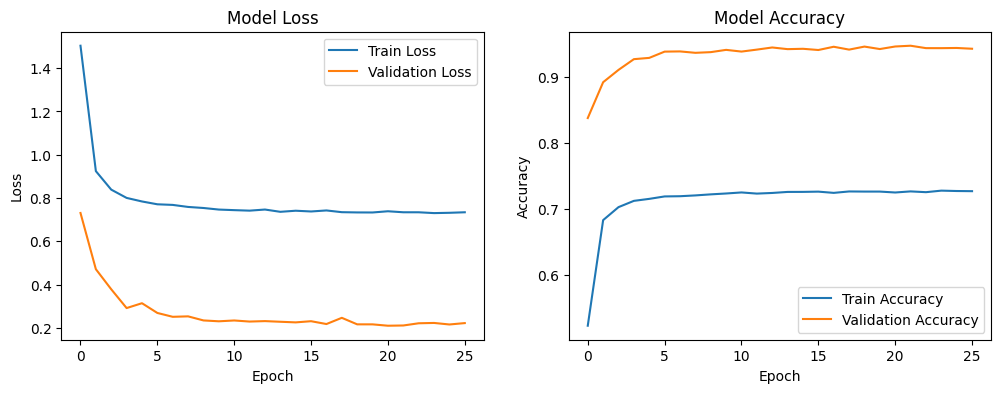

In [14]:

# 绘制训练和验证的损失和准确率曲线
def plot_training_history(history):
    # 绘制训练 & 验证损失值
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # 绘制训练 & 验证准确率值
    plt.subplot(1, 2, 2)
    plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.show()


plot_training_history(history)


881/881 [==============================] - 2s 2ms/step - loss: 0.2100 - categorical_accuracy: 0.9458

测试集的总体准确率: 0.95
881/881 [==============================] - 1s 1ms/step


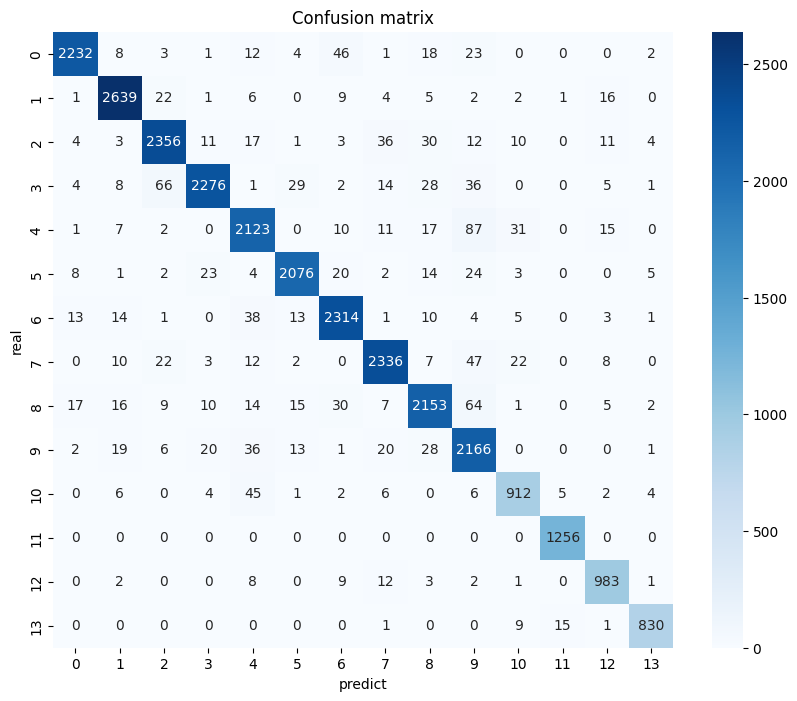

In [15]:

# 评估模型
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'\n测试集的总体准确率: {test_acc:.2f}')

# 获取预测结果
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# 绘制混淆矩阵图
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(NUM), yticklabels=range(NUM))
plt.xlabel('predict')
plt.ylabel('real')
plt.title('Confusion matrix')
plt.show()


In [16]:

# 评估模型
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'\n测试集的总体准确率: {test_acc:.2f}')

# 获取预测结果
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 计算每种类别的错误率
error_rates = {}
for label in range(NUM):
    label_indices = np.where(y_test_classes == label)[0]
    label_correct = np.sum(y_pred_classes[label_indices] == y_test_classes[label_indices])
    label_total = len(label_indices)
    label_error_rate = 1 - (label_correct / label_total)
    error_rates[label] = label_error_rate

print("\n每种类别的错误率:")
for label, error_rate in error_rates.items():
    print(f'类别 {label}: {error_rate:.2f}')


881/881 [==============================] - 2s 2ms/step - loss: 0.2100 - categorical_accuracy: 0.9458

测试集的总体准确率: 0.95
881/881 [==============================] - 1s 1ms/step

每种类别的错误率:
类别 0: 0.05
类别 1: 0.03
类别 2: 0.06
类别 3: 0.08
类别 4: 0.08
类别 5: 0.05
类别 6: 0.04
类别 7: 0.05
类别 8: 0.08
类别 9: 0.06
类别 10: 0.08
类别 11: 0.00
类别 12: 0.04
类别 13: 0.03


# 微调

In [17]:
url = "https://file.liux.pro/d/public/ai-arithmetic/mymnist14.tar.gz"
path_to_zip = tf.keras.utils.get_file(origin=url, cache_dir=".", cache_subdir="dataset", extract=True)
dataset_dir  = os.path.join(os.path.dirname(path_to_zip), 'mymnist14')
print(dataset_dir)

134224/134224 [==============================] - 0s 1us/step
./dataset/mymnist14


In [18]:
import copy
# 定义数据集路径
data_folder = dataset_dir

x_data = []
y_data = []
x_data_original = []  # 用于存储原始图像


from PIL import Image
import numpy as np

def center_image(image):
    # 转换为灰度图像
    gray_image = image.convert('L')
    
    # 将图像转换为 numpy 数组
    img_array = np.array(gray_image)
    
    # 计算四个方向的黑边宽度
    top = np.argmax(np.any(img_array != 0, axis=1))
    bottom = img_array.shape[0] - np.argmax(np.any(img_array != 0, axis=1)[::-1]) - 1
    left = np.argmax(np.any(img_array != 0, axis=0))
    right = img_array.shape[1] - np.argmax(np.any(img_array != 0, axis=0)[::-1]) - 1
    
    # 计算黑边的宽度
    top_black_border = top
    bottom_black_border = img_array.shape[0] - bottom - 1
    left_black_border = left
    right_black_border = img_array.shape[1] - right - 1
    
    # 计算需要平移的距离
    delta_vertical = (top_black_border - bottom_black_border) // 2
    delta_horizontal = (left_black_border - right_black_border) // 2
    
    # 使用 Pillow 的 `Image.transform` 来进行平移
    # 先计算图像的中心点位置
    width, height = image.size
    translation = (delta_horizontal, delta_vertical)
    
    # 使用 `Image.transform` 平移图像
    centered_image = image.transform(image.size, Image.AFFINE, (1, 0, translation[0], 0, 1, translation[1]))
    
    return centered_image




# 加载图像和标签
for label in range(NUM):
    label_folder = os.path.join(data_folder, str(label))
    images = []
    original_images = []

    # 使用tqdm显示进度条
    for img_name in tqdm(os.listdir(label_folder), desc=f'Loading images for label {label}'):
        img_path = os.path.join(label_folder, img_name)

        # 加载并处理图像
        image = Image.open(img_path).convert('L')  # 转换为灰度图
        image = image.resize((28, 28))  # 调整大小

        image_array = np.array(image)

        # 存储原始图像
        original_images.append(copy.deepcopy(image_array))

 
        images.append(np.array(center_image(image)))

    x_data.extend(images)
    y_data.extend([label] * len(images))
    x_data_original.extend(original_images)

# 转换为NumPy数组
x_data = np.array(x_data)
y_data = np.array(y_data)
x_data_original = np.array(x_data_original)

# 直接使用所有样本
x_balanced = x_data
y_balanced = y_data

# 按比例拆分数据集（例如，80% 训练集，20% 测试集）
x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size=0.2, random_state=42)

# 确保数据集的形状符合TensorFlow的要求
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32')
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32')

# 创建一个ImageDataGenerator实例并设置增强参数
datagen = ImageDataGenerator(
    rotation_range=1,
    zoom_range=(0.7, 1.2),
    # width_shift_range=0.1,
    # height_shift_range=0.05
)
# 适配数据生成器
datagen.fit(x_train)

# 打印每种图片的数量
unique, counts = np.unique(y_balanced, return_counts=True)
print("每种图片数量:")
for label, count in zip(unique, counts):
    print(f'类别 {label}: {count} 张')


Loading images for label 13: 100%|██████████| 110/110 [00:00<00:00, 3429.42it/s]

每种图片数量:
类别 0: 160 张
类别 1: 115 张
类别 2: 109 张
类别 3: 106 张
类别 4: 154 张
类别 5: 100 张
类别 6: 120 张
类别 7: 107 张
类别 8: 121 张
类别 9: 112 张
类别 10: 100 张
类别 11: 148 张
类别 12: 114 张
类别 13: 110 张


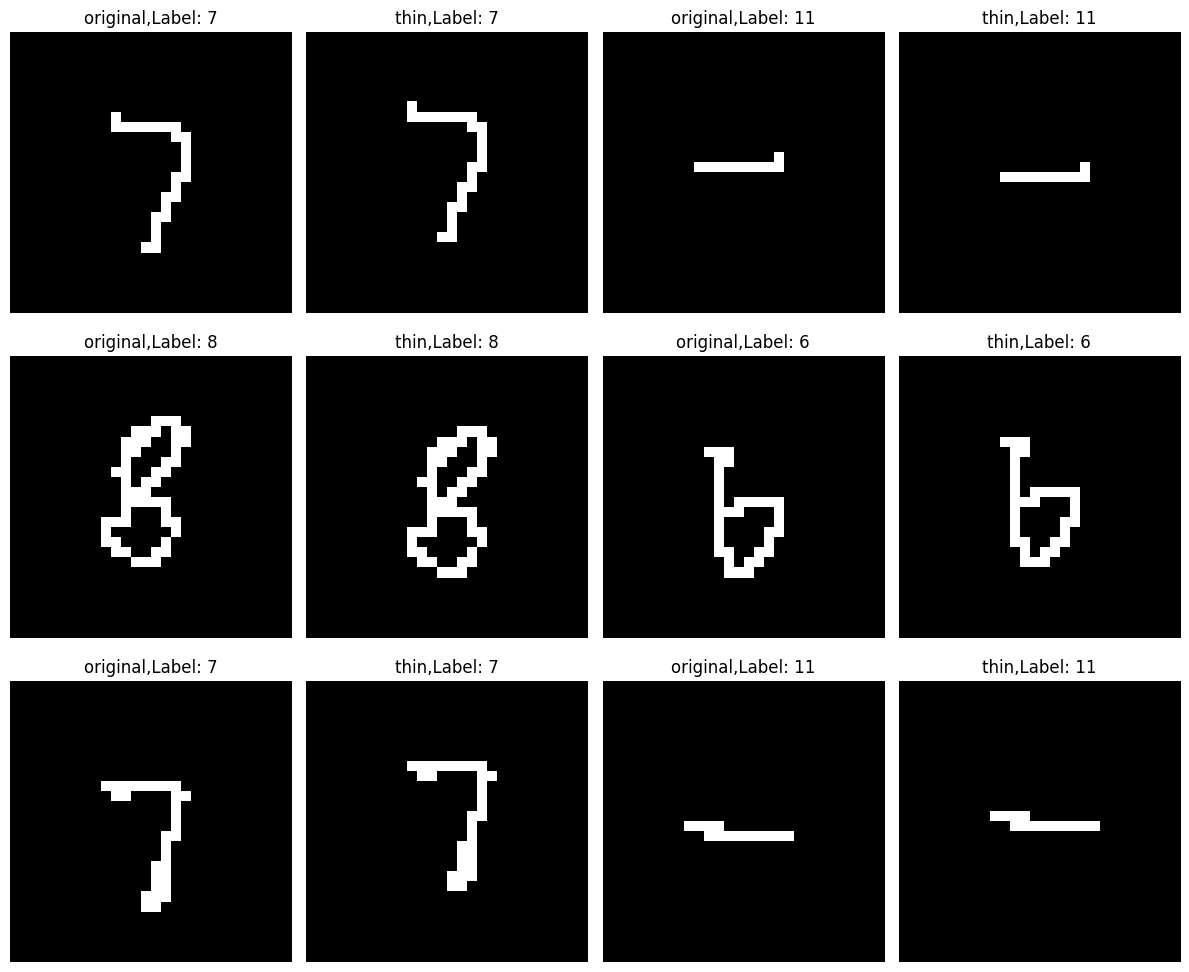

In [19]:
# 显示几个原始图像与细化后的对比图
fig, axes = plt.subplots(3, 4, figsize=(12, 10))

# 显示几个样本
for i in range(3):
    for j in range(2):
        idx = np.random.choice(len(x_data))  # 随机选择一个索引
        axes[i, j * 2].imshow(x_data_original[idx], cmap='gray')
        axes[i, j * 2].set_title(f"original,Label: {y_balanced[idx]}")
        axes[i, j * 2].axis('off')

        axes[i, j * 2 + 1].imshow(x_data[idx], cmap='gray')
        axes[i, j * 2 + 1].set_title(f"thin,Label: {y_balanced[idx]}")
        axes[i, j * 2 + 1].axis('off')

plt.tight_layout()
plt.show()

In [20]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1) / 255
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1) / 255

y_train = to_categorical(y_train, num_classes=NUM)
y_test = to_categorical(y_test, num_classes=NUM)

In [21]:

# 评估模型
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'\n测试集的总体准确率: {test_acc:.2f}')

# 获取预测结果
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 计算每种类别的错误率
error_rates = {}
for label in range(NUM):
    label_indices = np.where(y_test_classes == label)[0]
    label_correct = np.sum(y_pred_classes[label_indices] == y_test_classes[label_indices])
    label_total = len(label_indices)
    label_error_rate = 1 - (label_correct / label_total)
    error_rates[label] = label_error_rate

print("\n每种类别的错误率:")
for label, error_rate in error_rates.items():
    print(f'类别 {label}: {error_rate:.2f}')


11/11 [==============================] - 0s 6ms/step - loss: 1.1666 - categorical_accuracy: 0.6637

测试集的总体准确率: 0.66
11/11 [==============================] - 0s 1ms/step

每种类别的错误率:
类别 0: 0.97
类别 1: 0.14
类别 2: 0.50
类别 3: 0.23
类别 4: 0.28
类别 5: 0.50
类别 6: 0.44
类别 7: 0.12
类别 8: 0.00
类别 9: 0.10
类别 10: 0.53
类别 11: 0.00
类别 12: 0.86
类别 13: 0.05


In [22]:
for layer in model.layers[:7]:  # 这里的 7 指的是冻结前四层
    layer.trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 4)         104       
                                                                 
 batch_normalization (Batch  (None, 14, 14, 4)         16        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 14, 14, 4)         0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 4)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 4)           404       
                                                                 
 batch_normalization_1 (Bat  (None, 5, 5, 4)           16        
 chNormalization)                                       

In [23]:
# 定义早停回调
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# 定义模型检查点回调，保存验证损失最小的模型
model_checkpoint = ModelCheckpoint('best_model_fine_tuning.h5', monitor='val_loss', save_best_only=True, mode='min')

history = None
# windows 开多线程后会卡死，不知道为什么，垃圾系统
if sys.platform.startswith('win'):
    history = model.fit(x_train,y_train,
                        batch_size=128,
                        epochs=30,
                        verbose=2,
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping, model_checkpoint],
                        shuffle=True)
else:
    history = model.fit(x_train,y_train,
                        batch_size=30,
                        epochs=100,
                        verbose=2,
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping, model_checkpoint],
                        shuffle=True,
                        max_queue_size=100,
                        workers = 8,
                        use_multiprocessing=True)

# 加载最佳模型权重
model.load_weights('best_model_fine_tuning.h5')

Epoch 1/100
45/45 - 0s - loss: 1.2420 - categorical_accuracy: 0.5843 - val_loss: 0.3475 - val_categorical_accuracy: 0.9018 - 432ms/epoch - 10ms/step
Epoch 2/100


/root/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 - 0s - loss: 0.8835 - categorical_accuracy: 0.6910 - val_loss: 0.1901 - val_categorical_accuracy: 0.9702 - 202ms/epoch - 4ms/step
Epoch 3/100
45/45 - 0s - loss: 0.7923 - categorical_accuracy: 0.7067 - val_loss: 0.1461 - val_categorical_accuracy: 0.9792 - 201ms/epoch - 4ms/step
Epoch 4/100
45/45 - 0s - loss: 0.7834 - categorical_accuracy: 0.7119 - val_loss: 0.1152 - val_categorical_accuracy: 0.9851 - 200ms/epoch - 4ms/step
Epoch 5/100
45/45 - 0s - loss: 0.7192 - categorical_accuracy: 0.7306 - val_loss: 0.0964 - val_categorical_accuracy: 0.9911 - 203ms/epoch - 5ms/step
Epoch 6/100
45/45 - 0s - loss: 0.6637 - categorical_accuracy: 0.7396 - val_loss: 0.0771 - val_categorical_accuracy: 0.9940 - 202ms/epoch - 4ms/step
Epoch 7/100
45/45 - 0s - loss: 0.6321 - categorical_accuracy: 0.7575 - val_loss: 0.0641 - val_categorical_accuracy: 0.9970 - 203ms/epoch - 5ms/step
Epoch 8/100
45/45 - 0s - loss: 0.6499 - categorical_accuracy: 0.7410 - val_loss: 0.0558 - val_categorical_accuracy: 0.9970 -

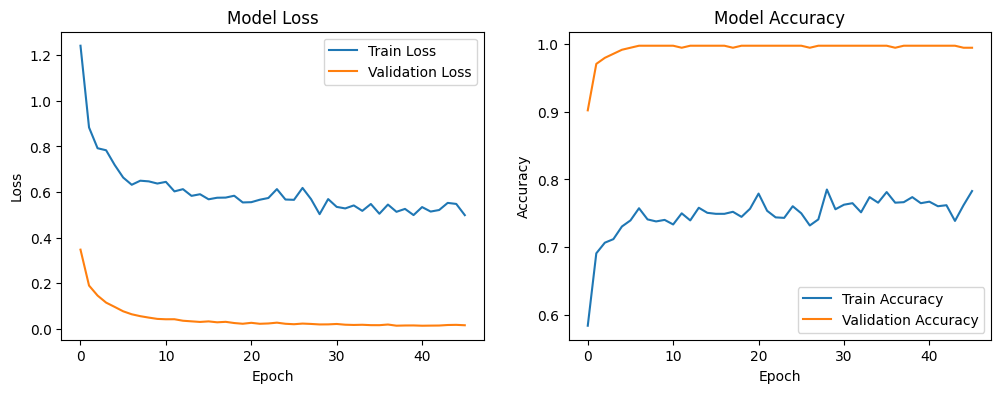

In [24]:

# 绘制训练和验证的损失和准确率曲线
def plot_training_history(history):
    # 绘制训练 & 验证损失值
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # 绘制训练 & 验证准确率值
    plt.subplot(1, 2, 2)
    plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.show()


plot_training_history(history)


11/11 [==============================] - 0s 2ms/step - loss: 0.0139 - categorical_accuracy: 0.9970

测试集的总体准确率: 1.00
11/11 [==============================] - 0s 1ms/step


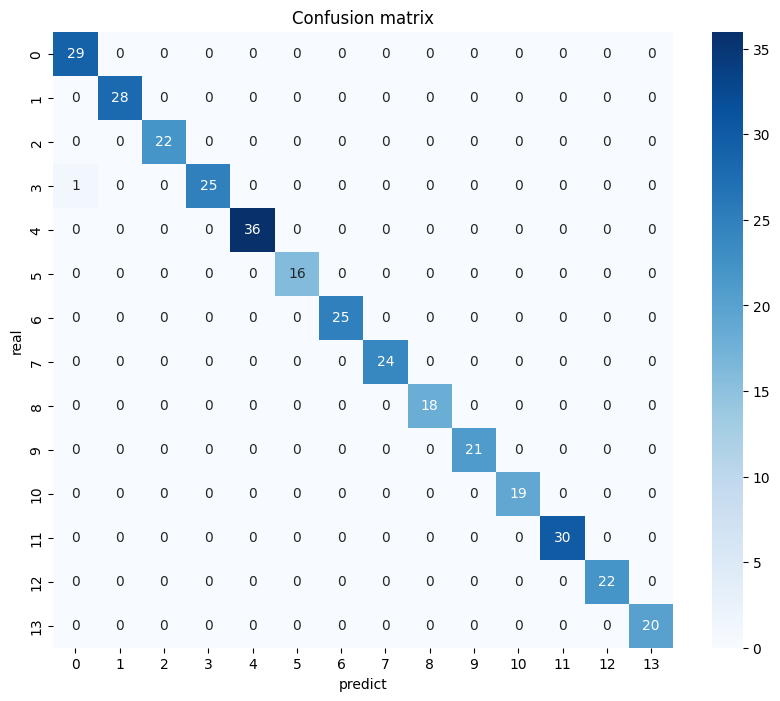

In [25]:

# 评估模型
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'\n测试集的总体准确率: {test_acc:.2f}')

# 获取预测结果
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# 绘制混淆矩阵图
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(NUM), yticklabels=range(NUM))
plt.xlabel('predict')
plt.ylabel('real')
plt.title('Confusion matrix')
plt.show()


In [26]:

# 评估模型
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'\n测试集的总体准确率: {test_acc:.2f}')

# 获取预测结果
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# 计算每种类别的错误率
error_rates = {}
for label in range(NUM):
    label_indices = np.where(y_test_classes == label)[0]
    label_correct = np.sum(y_pred_classes[label_indices] == y_test_classes[label_indices])
    label_total = len(label_indices)
    label_error_rate = 1 - (label_correct / label_total)
    error_rates[label] = label_error_rate

print("\n每种类别的错误率:")
for label, error_rate in error_rates.items():
    print(f'类别 {label}: {error_rate:.2f}')


11/11 [==============================] - 0s 2ms/step - loss: 0.0139 - categorical_accuracy: 0.9970

测试集的总体准确率: 1.00
11/11 [==============================] - 0s 1ms/step

每种类别的错误率:
类别 0: 0.00
类别 1: 0.00
类别 2: 0.00
类别 3: 0.04
类别 4: 0.00
类别 5: 0.00
类别 6: 0.00
类别 7: 0.00
类别 8: 0.00
类别 9: 0.00
类别 10: 0.00
类别 11: 0.00
类别 12: 0.00
类别 13: 0.00


In [27]:
# 导出模型
model.export("mnist_fine_tuning")
# 调用转换脚本
!python tools/h5_to_tflite.py mnist_fine_tuning mnist_fine_tuning.tflite 1 dataset/mymnist14  0to1
!python tools/tflite2tmdl.py mnist_fine_tuning.tflite mnist_fine_tuning.tmdl int8 1 28,28,1 {NUM} 1

INFO:tensorflow:Assets written to: mnist_fine_tuning/assets


INFO:tensorflow:Assets written to: mnist_fine_tuning/assets


Saved artifact at 'mnist_fine_tuning'. The following endpoints are available:

* Endpoint 'serve'
  Args:
    args_0: float32 Tensor, shape=(None, 28, 28, 1)
  Returns:
    float32 Tensor, shape=(None, 14)
2024-11-15 15:33:10.060214: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-15 15:33:10.103115: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-15 15:33:10.103164: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-15 15:33:10.103197: E tensorflow/compiler/xla/stream_executor/cuda/cu